<a id='summary'></a>
# Creating activity chains from EGT

## Summary
* [Loading depl](#depl)


* [Generating activity_chains](#activity_chains)
    * [Helper functions for the processing logic](#logic)
    * [Running generation](#running)
    * [Adding empty agendas](#empty)
    * [Flattening chains](#flat)
    
    
* [Sanity Checks](#sanity)


* [Adding side infos](#side_info)
    * [autonomy](#autonomy)
    * [work_mode_in_agenda](#work_mode_in_agenda)
    * [work_in_agenda](#work_in_agenda)
    * [commute_mode_in_egt](#commute_mode_in_egt)
    
    
* [df_trips](#df_trips)
* [Exporting](#exporting)


* [Result visualisation](#viz)
    * [Agendas with twice the same primary activity](#primary)
    * [Agendas goingon after midnight](#midnight)
    * [Agendas not ending at home](#homeend)
    * [Static & empty agendas](#static)
    * [Static & empty agendas in raw EGT](#static_egtraw)
    
    
* [Code visualisation](#code_viz)

In [7]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import os

from utils.chrono import Chrono


In [8]:


with open('config.json', 'r') as config_path:
    config = json.load(config_path)
    
timesteps = np.array(config['timesteps'])


<a id='depl'></a>
# Loading depl
* Already pre-processed by egt_preprocessing
* **D3**: ZF of origin
* **D7**: ZF of destination
* **D4**: heure de départ du déplacement
* **D8**: heure d'arrivée du déplacement
* **D11**: L2 distance of trip
* [back to summary](#summary)

In [9]:
depl_path = os.path.join(config['outdata_dir']['path'], 
                         config['outdata_dir']['HTS_depl_filtered_filename'])
print('Loading from {}'.format(depl_path))
depl_ori = pd.read_csv(depl_path, dtype={'D4':str, 'D8':str, 'id_per':str})

depl_ori['D4_minutes'] = depl_ori['D4'].str[:2].astype(int)*60 + depl_ori['D4'].str[2:].astype(int)
depl_ori['D8_minutes'] = depl_ori['D8'].str[:2].astype(int)*60 + depl_ori['D8'].str[2:].astype(int)

depl_ori.head()
print(len(depl_ori))

Loading from /Users/benoit/Desktop/Pro/210526-fusion/outdata/egt_lyon_pop_sample/depl.csv
55112


In [10]:
depl_ori['is_commute'] = (((depl_ori['origin_motive']==0)&(depl_ori['destination_motive']==1))|
                          ((depl_ori['origin_motive']==0)&(depl_ori['destination_motive']==2))|
                          ((depl_ori['origin_motive']==1)&(depl_ori['destination_motive']==0))|
                          ((depl_ori['origin_motive']==2)&(depl_ori['destination_motive']==0))
                         )
print(depl_ori.groupby('is_commute')['D11'].mean())
print(depl_ori.groupby('is_commute')['D11'].median())
print(depl_ori['is_commute'].mean())

is_commute
False    2405.919017
True     3998.655102
Name: D11, dtype: float64
is_commute
False    1140.0
True     2450.0
Name: D11, dtype: float64
0.31797067789229205


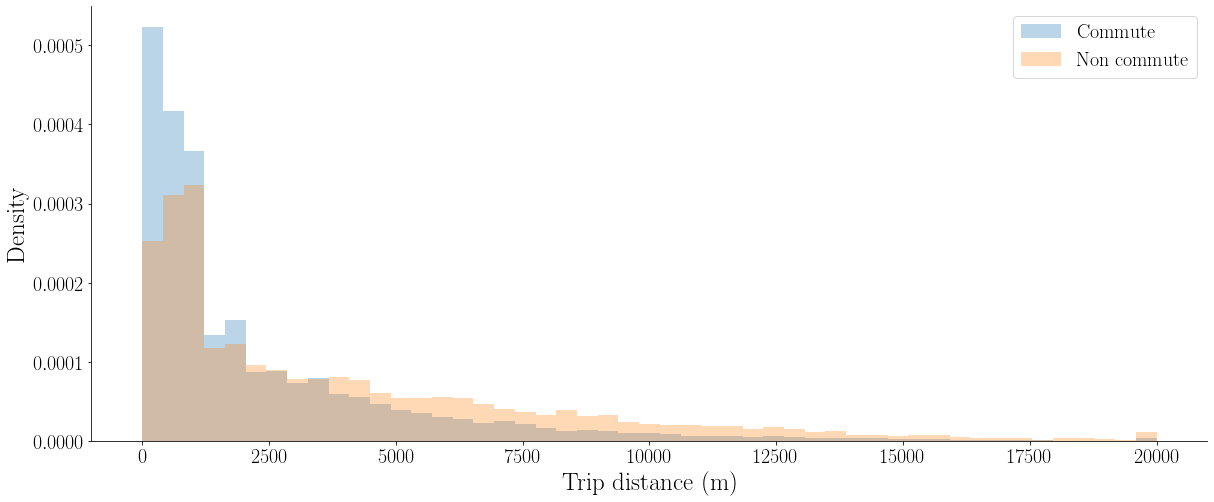

In [12]:
fac_font = 2.5
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10*fac_font,
    "font.size": 10*fac_font,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8*fac_font,
    "xtick.labelsize": 8*fac_font,
    "ytick.labelsize": 8*fac_font
}
plt.rcParams.update(tex_fonts)

fig, ax = plt.subplots(figsize=(20,8))
max_d = 20000
depl_ori['D11_maxd'] = np.clip(depl_ori['D11'], 0, max_d)
bins = np.linspace(0,max_d, 50)


ax.hist(depl_ori[~depl_ori['is_commute']]['D11_maxd'], density=True, bins=bins, alpha=0.3, label='Commute')
ax.hist(depl_ori[depl_ori['is_commute']]['D11_maxd'], density=True, bins=bins, alpha=0.3, label='Non commute')

ax.set_xlabel('Trip distance (m)')
ax.set_ylabel('Density')
ax.spines.top.set_visible(False)
ax.spines.right.set_visible(False)
ax.legend()

outpath = os.path.join(config['outfig_dir'], 'commute_distance.pdf')
plt.savefig(outpath, bbox_inches='tight')

plt.show()

<a id='activity_chains'></a>
# Generation of activity chains
* [back to summary](#summary)

<a id='logic'></a>
## Logic functions


In [5]:
def get_most_important_motive_and_duration(motive_1, duration_1, zone_1, arrival_time_1, 
                                           motive_2, duration_2, zone_2, arrival_time_2):
    if motive_1 is None:
        motive = motive_2
        duration = duration_2
        zone = zone_2
        arrival_time = arrival_time_2
        
    elif motive_1 in [0,1,2] and motive_2 not in [0,1,2]:
        motive = motive_1
        duration = duration_1
        zone = zone_1
        arrival_time = arrival_time_1
        
    elif motive_2 in [0,1,2] and motive_1 not in [0,1,2]:
        motive = motive_2
        duration = duration_2        
        zone = zone_2
        arrival_time = arrival_time_2
        
    elif duration_2 > duration_1:
        motive = motive_2
        duration = duration_2   
        zone = zone_2
        arrival_time = arrival_time_2
        
    else: 
        motive = motive_1
        duration = duration_1
        zone = zone_1
        arrival_time = arrival_time_1
    return motive, duration, zone, arrival_time

def get_longest_mode_and_distance(mode_1, distance_1, mode_2, distance_2):
    if distance_1 > distance_2:
        return mode_1, distance_1
    else:
        return mode_2, distance_2

def add_activity(chain, row, first_activity):
    last_activity = first_activity if len(chain)==0 else chain[-1][1]
    if row[1] in [0,1,2] and last_activity == row[1]:
        pass
    else:
        chain.append(row)
        
def detect_outsider(rows):
    """
    return True iff one of the trips is long compared to the study zone
    """
    # D11: distance of trip
    return rows['D11'].max() > 30000

In [6]:
agenda_report_df = pd.DataFrame()

def create_chain(rows, min_activity_duration=20, min_trip_len=100):
    """
    creates a chain of trips from all trips of one person, with filtering rules
     described in the paper.
    - Once all these rules have been applied, check for consecutive primary motives:
        if motive is primary and equal to the previous one, merge the two activities:
        - with the common motive
        - transport mode of the first activity
        - start time of the first activity
        - this is equivalent to discarding current activity.
        
    also keep track of zones for investigations
    """
    activity_start = rows['D8_minutes'].values
    activity_end = np.concatenate([rows['D4_minutes'].values[1:], [np.inf]])
    activity_lengths = activity_end-activity_start

    first_activity = rows['origin_motive'].values[0]

    chain = []
    # mode -
    # motif - 
    # time of departure for the activity - 
    # duration of activity (not counting travel time) - 
    # distance of travel to get to the activity
    # zone
    # time of arrival to the activity
    
    candidate = None
    for i, row in rows.reset_index().iterrows():
        curr_mode = row['MODP']
        curr_motive = row['destination_motive']
        curr_time = row['D4']
        curr_duration = activity_lengths[i]
        curr_distance = row['D11']
        curr_zone = row['D7']  # destination zone
        curr_arrival_time = row['D8']
        
        distance_too_short = curr_distance < min_trip_len
        activity_too_short = curr_duration < min_activity_duration
        
        if candidate:
            candidate_mode, candidate_distance = candidate[0], candidate[4]
            if distance_too_short:
                if activity_too_short:
                    # update mode of the candidate
                    candidate[0], candidate[4] = get_longest_mode_and_distance(candidate_mode, candidate_distance, 
                                                                               curr_mode, curr_distance)
                    
                    # keep candidate start time: nothing to do.
                    
                else:
                    # get longest mode
                    mode, distance = get_longest_mode_and_distance(candidate_mode, candidate_distance, curr_mode, curr_distance)

                    # keep motive of most important activity (dest vs ori)
                    ori_motive = row['origin_motive']
                    ori_duration = activity_lengths[i-1]  # got a candidate so i>0
                    ori_zone = row['D3']
                    ori_arrival_time = row['D8']
                    motive, duration, zone, arrival_time = get_most_important_motive_and_duration(ori_motive, ori_duration, ori_zone, ori_arrival_time, 
                                                                                                  curr_motive, curr_duration, curr_zone, curr_arrival_time)
                    add_activity(chain, 
                                 [mode, motive, candidate[2], duration, distance, zone, arrival_time], 
                                 first_activity)
                    candidate = None
                    
            else: 
                if activity_too_short:
                    # update mode of the candidate
                    candidate[0], candidate[4] = get_longest_mode_and_distance(candidate_mode, candidate_distance, curr_mode, curr_distance)
                    # keep candidate start time.
                    
                else:
                    # get longest mode
                    mode, distance = get_longest_mode_and_distance(candidate_mode, candidate_distance, 
                                                                   curr_mode, curr_distance)
                    add_activity(chain, 
                                 [mode, curr_motive, candidate[2], curr_duration, distance, curr_zone, curr_arrival_time], 
                                 first_activity)
                    candidate = None

        else:
            if distance_too_short:
                if activity_too_short:
                    candidate = [curr_mode, None, curr_time, curr_duration, curr_distance, None, None]
                else:
                    if len(chain)==0:
                        pass
                    else:
                        [prev_mode, prev_motive, prev_time, prev_duration, prev_distance, prev_zone, prev_arrival_time] = chain.pop()
                        # Update previous activity
                        
                        motive, duration, zone, arrival_time = get_most_important_motive_and_duration(prev_motive, prev_duration, prev_zone, prev_arrival_time, 
                                                                                                      curr_motive, curr_duration, curr_zone, curr_arrival_time)
                        mode, distance = get_longest_mode_and_distance(prev_mode, prev_distance, 
                                                                       curr_mode, curr_distance)
                        add_activity(chain, 
                                     [mode, motive, prev_time, duration, distance, zone, arrival_time],
                                     first_activity)

            else:
                if activity_too_short:
                    candidate = [curr_mode, None, curr_time, curr_duration, curr_distance, None, None]
                else:
                    add_activity(chain, 
                                 [curr_mode, curr_motive, curr_time, curr_duration, curr_distance, curr_zone, curr_arrival_time],
                                 first_activity)
    chain = np.array(chain)
    if chain.shape[0]==0:
        return []
    elif len(chain.shape) == 1:
        return [list(chain)]
    return list(zip(chain[:, 0], # mode
                    chain[:, 1], # motif
                    chain[:, 2], # departure time
                    chain[:, 4], # distance
                    chain[:, 5], # Zone: just to get an EGT OD matrix
                    chain[:, 6]  # Arrival time: not used at the moment
                   ))


def get_last_motif(row, max_chain_len):
    last_motif = 0
    motif = 0
    for i in range(1, max_chain_len+1):
        motif = row['dep_{}_motif'.format(i)]
        if np.isnan(motif):
            return last_motif
        else:
            last_motif=motif
    return last_motif


<a id='running'></a>
## Running
* [back to summary](#summary)

In [7]:
# 00:01:00
from tqdm import tqdm
tqdm.pandas()  # for progress_apply

filter_trips_under = 100
min_activity_duration = 20

c=Chrono('Creating chains...')
depl_filtered = (depl_ori
                 .groupby('id_per')
                 .progress_apply(lambda r : pd.Series({'chain': create_chain(r, min_activity_duration,
                                                                       filter_trips_under),
                                              'dep_0_motif': r['origin_motive'].values[0],
                                              'dep_0_zone': r['D3'].values[0],
                                              'outsider': detect_outsider(r),
                                             }))
                 .reset_index())

depl_filtered['chain_len'] = depl_filtered['chain'].str.len()
c.write('{} depl'.format(depl_filtered['chain_len'].sum()))
depl_filtered['id_per'] = depl_filtered['id_per'].astype(float)

max_chain_len = int(depl_filtered['chain_len'].max())

c.done()
c.write('{} agendas out of {} ({:.2%}) are made empty by the filtering'.format(
    len(depl_filtered[depl_filtered['chain_len']==0]),
    len(depl_ori['id_per'].unique()),
    len(depl_filtered[depl_filtered['chain_len']==0])/len(depl_ori['id_per'].unique())
))
depl_filtered.head()

14:47:52	Creating chains...


100%|████████████████████████████████████| 14988/14988 [00:22<00:00, 677.24it/s]

00:00:22	40085 depl
00:00:22	Work complete !
00:00:22	1132 agendas out of 14988 (7.55%) are made empty by the filtering


,id_per,chain,dep_0_motif,dep_0_zone,outsider,chain_len
0,1.010011e+09,"[(3, 2, 0750, 2890, 119651, 0800), (3, 0, 1700...",0,101001,False,2
1,1.010018e+08,"[(3, 4, 1045, 1110, 102001, 1100), (3, 0, 1145...",0,101001,False,2
2,1.010018e+08,"[(3, 1, 0820, 2590, 104001, 0840), (3, 0, 1745...",0,101001,False,2
3,1.010018e+08,"[(3, 2, 0728, 2390, 212003, 0738), (3, 0, 1700...",0,101001,False,2
4,1.010021e+09,"[(3, 3, 1000, 2230, 128003, 1030), (3, 0, 1230...",0,101002,False,4


<a id='empty'></a>
## Adding empty agenda
* Some people may have answered EGT to give their agenda (field `PENQ` set to True) but happened to have no agenda (nothing in the dataset `dep`).
* We add those people here.
* Note that at this step of the preprocessing, some filtered activity chains are already empty even though they are made from non-empty chains.
* [back to summary](#summary)

In [8]:
c = Chrono('Loading HTS...')
egt_path = os.path.join(config['outdata_dir']['path'], 
                        config['outdata_dir']['HTS_filtered_filename'])
egt = pd.read_csv(egt_path)
per_answered_agendas = egt[egt['PENQ']==True][['id_per', 'zf_home', 'scaling_factor_person']]

print('{} HTS rows have an agenda, {:.0f} persons with rescaling'.format(len(per_answered_agendas), 
                                                                         per_answered_agendas['scaling_factor_person'].sum()))

# surprisingly hard to fillna with a list, so we use this and merge later:
per_answered_agendas['chain_empty'] = [[] for _ in range(len(per_answered_agendas))] 

prev_len = len(depl_filtered)
depl_filtered = depl_filtered.merge(per_answered_agendas, on='id_per', how='outer')
c.write('added {} empty agendas'.format(len(depl_filtered)-prev_len))

depl_filtered['dep_0_zone'] = depl_filtered['dep_0_zone'].fillna(depl_filtered['zf_home'])
depl_filtered['chain'] = depl_filtered['chain'].fillna(depl_filtered['chain_empty'])
depl_filtered['dep_0_motif'] = depl_filtered['dep_0_motif'].fillna(0)
depl_filtered['chain_len'] = depl_filtered['chain_len'].fillna(0)
depl_filtered['outsider'] = depl_filtered['outsider'].fillna(False)

depl_filtered = depl_filtered.drop(columns=['chain_empty'])
c.done()

14:48:14	Loading HTS...
16941 HTS rows have an agenda, 1249547 persons with rescaling
00:00:00	added 2722 empty agendas
00:00:00	Work complete !


In [9]:
depl_filtered.head()

,id_per,chain,dep_0_motif,dep_0_zone,outsider,chain_len,zf_home,scaling_factor_person
0,1.010011e+09,"[(3, 2, 0750, 2890, 119651, 0800), (3, 0, 1700...",0.0,101001.0,False,2.0,101001.0,54.14797
1,1.010018e+08,"[(3, 4, 1045, 1110, 102001, 1100), (3, 0, 1145...",0.0,101001.0,False,2.0,101001.0,29.75996
2,1.010018e+08,"[(3, 1, 0820, 2590, 104001, 0840), (3, 0, 1745...",0.0,101001.0,False,2.0,101001.0,51.85581
3,1.010018e+08,"[(3, 2, 0728, 2390, 212003, 0738), (3, 0, 1700...",0.0,101001.0,False,2.0,101001.0,53.59816
4,1.010021e+09,"[(3, 3, 1000, 2230, 128003, 1030), (3, 0, 1230...",0.0,101002.0,False,4.0,101002.0,50.09030


<a id='flat'></a>
## Flattening chains
* `depl_filtered` has just a column `chain` holding a list. We flatten it into multiple columns, one for each element.
* [back to summary](#summary)

In [10]:
def fit_hourstr_to_timesteps(hourstr, timesteps):
    """
    fit hour of format 'hhmm' to the corresponding timestep
        retrieve the last step s.t. step<=hour by inverting the array before argmax
    """
    hour = int(hourstr[:2])%24
    return timesteps[np.searchsorted(timesteps, hour, side='right')-1]


def flatten_chain(row):
    """
    explodes the `chain` column into enough columns to store all the activity informations
    """
    chain = row['chain']
    if len(chain)==0:
        return row
    for i, (mode, motif, hourstr, distance, zone, arrival_time) in enumerate(chain):
        row['dep_{}_mode'.format(i+1)] = mode
        row['dep_{}_motif'.format(i+1)] = motif
        timestep = fit_hourstr_to_timesteps(hourstr, timesteps)
        row['dep_{}_time'.format(i+1)] = timestep
        row['dep_{}_l2'.format(i+1)] = distance
        row['dep_{}_zone'.format(i+1)] = zone
        row['dep_{}_arrival_time'.format(i+1)] = arrival_time
    return row

activity_chains = depl_filtered.copy()

c=Chrono('Expanding list in multiple columns...')
for i in range(1, max_chain_len+1):
    activity_chains['dep_{}_mode'.format(i)] = np.nan
    activity_chains['dep_{}_motif'.format(i)] = np.nan
    activity_chains['dep_{}_time'.format(i)] = np.nan
    activity_chains['dep_{}_l2'.format(i)] = np.nan
    activity_chains['dep_{}_zone'.format(i)] = np.nan
    activity_chains['dep_{}_arrival_time'.format(i)] = np.nan

activity_chains = activity_chains.progress_apply(flatten_chain, axis=1).drop(columns=['chain']).astype(float)
c.done()
activity_chains.head()

14:48:14	Expanding list in multiple columns...


100%|███████████████████████████████████| 17710/17710 [00:05<00:00, 3451.22it/s]


00:00:05	Work complete !


,id_per,dep_0_motif,dep_0_zone,outsider,chain_len,zf_home,scaling_factor_person,dep_1_mode,dep_1_motif,dep_1_time,...,dep_9_time,dep_9_l2,dep_9_zone,dep_9_arrival_time,dep_10_mode,dep_10_motif,dep_10_time,dep_10_l2,dep_10_zone,dep_10_arrival_time
0,1.010011e+09,0.0,101001.0,0.0,2.0,101001.0,54.14797,3.0,2.0,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.010018e+08,0.0,101001.0,0.0,2.0,101001.0,29.75996,3.0,4.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.010018e+08,0.0,101001.0,0.0,2.0,101001.0,51.85581,3.0,1.0,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.010018e+08,0.0,101001.0,0.0,2.0,101001.0,53.59816,3.0,2.0,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.010021e+09,0.0,101002.0,0.0,4.0,101002.0,50.09030,3.0,3.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<a id='side_info'></a>
# Adding side infos

## Adding zone-to-zone distance

### getting zone to zone distances

In [11]:
zf_path = os.path.join(config['outdata_dir']['path'], config['outdata_dir']['HTS_gis_filtered_filename'])
zf = gpd.read_file(zf_path)
zf['ZF2015_Nouveau_codage'] = zf['ZF2015_Nouveau_codage'].astype(float)
zf['x'] = zf.centroid.x
zf['y'] = zf.centroid.y

zf['cart_key'] = 1
zf_couples = pd.DataFrame(zf[['ZF2015_Nouveau_codage', 'cart_key','x','y']].merge(
                           zf[['ZF2015_Nouveau_codage', 'geometry', 'cart_key','x','y']], 
                           on='cart_key', suffixes=('_o','_d')))

zf_couples['centroid_dist'] = np.sqrt((zf_couples['x_o']-zf_couples['x_d'])**2 + 
                                       (zf_couples['y_o']-zf_couples['y_d'])**2)


### binning zone to zone distance

In [12]:
distbin_limits = config['distbin_limits']+[np.inf]

zf_couples['dist_bin'] = pd.cut(zf_couples['centroid_dist'], bins=distbin_limits, 
                                                   include_lowest=True,
                                                  labels=range(len(distbin_limits)-1)).astype(float)
zf_couples = zf_couples[['ZF2015_Nouveau_codage_o', 'ZF2015_Nouveau_codage_d', 'dist_bin']]

In [13]:
for i in range(1, max_chain_len+1):
    activity_chains = (activity_chains
     .merge(zf_couples, left_on=('dep_{}_zone'.format(i-1), 'dep_{}_zone'.format(i)),
                          right_on = ('ZF2015_Nouveau_codage_o', 'ZF2015_Nouveau_codage_d'),
                          how='left'
                         )
     .drop(columns=['ZF2015_Nouveau_codage_o', 'ZF2015_Nouveau_codage_d'])
     .rename(columns={'dist_bin':'dep_{}_distbin'.format(i)})
    
    )

<a id='autonomy'></a>
## autonomy
* Some agendas have no trips (so only 1 activity), but the activity is not home
* In those cases, we set the autonomy to 0 even though there is technically one non-fixed activity.
* [back to summary](#summary)

In [14]:

def get_autonomy(agendas_df):
    max_chain_len = int(agendas_df['chain_len'].max())
    motif_cols = ['dep_{}_motif'.format(i) for i in range(max_chain_len+1)]
    motives = agendas_df[motif_cols].fillna(0).values

    max_autonomy = np.zeros(len(agendas_df))
    curr_autonomy = np.zeros(len(agendas_df))
    
    for i in range(max_chain_len):
        curr_autonomy[motives[:,i]!=0] += 1
        curr_autonomy[(motives[:,i]==0) | (agendas_df['chain_len']==0)] = 0
        max_autonomy = np.maximum(curr_autonomy, max_autonomy)
    return max_autonomy

activity_chains['autonomy'] = get_autonomy(activity_chains)
# depl_filtered = depl_filtered.merge(activity_chains[['id_per', 'autonomy']], on='id_per')

<a id='work_mode_in_agenda'></a>
## first mode used to go to work
* [back to summary](#summary)

In [15]:
activity_chains['work_tm_in_agenda'] = None
for i in range(1, max_chain_len+1):
    activity_chains.loc[(activity_chains['dep_{}_motif'.format(i)]==1) & 
                        (activity_chains['work_tm_in_agenda'].isna()), 'work_tm_in_agenda'] = activity_chains['dep_{}_mode'.format(i)]

# depl_filtered = depl_filtered.merge(activity_chains[['id_per', 'work_tm_in_agenda']], on='id_per')

<a id='work_in_agenda'></a>
## work or study in agenda
* Adding column `need_commute` set to true iff the activty chains either has a work or a study activity
* [back to summary](#summary)

In [16]:
activity_chains['work_in_agenda'] = False
for i in range(1, max_chain_len+1):
    activity_chains['work_in_agenda'] = activity_chains['work_in_agenda'] | (activity_chains['dep_{}_motif'.format(i)]==1)

activity_chains['study_in_agenda'] = False
for i in range(1, max_chain_len+1):
    activity_chains['study_in_agenda'] = activity_chains['study_in_agenda'] | (activity_chains['dep_{}_motif'.format(i)]==2)

activity_chains['need_commute'] = activity_chains['work_in_agenda'] | activity_chains['study_in_agenda']


<a id='df_trips'></a>
# Preprocessing for df_trips

* Same infos as in `activity_chains` but in another format
* used only for Horl & axhausen's method of spatialisation
* Target schema:
    * **person_id**
    * **trip_index**
    * **departure_time**
    * **arrival_time**
    * **preceding_purpose**
    * **following_purpose**
    * **is_first_trip**
    * **is_last_trip**
    * **trip_duration**
    * **activity_duration**
    * **mode**
* [back to summary](#summary)

In [17]:
c = Chrono('Exploding...')
df_trips = depl_filtered.explode('chain').reset_index(drop=True)
df_trips = df_trips.dropna()

c.write('Renaming...')
df_trips = df_trips.rename(columns={'id_per':'person_id'})


c.write('Flattening...')

df_trips[['mode', 'motif', 'departure_time', 
          'distance', 'zone', 'arrival_time']] = pd.DataFrame(df_trips['chain'].tolist(), 
                                                                index=df_trips.index)

df_trips['departure_time'] = 60*df_trips['departure_time'].str[:2].astype(int) + df_trips['departure_time'].str[2:].astype(int)

df_trips['arrival_time'] = 60*df_trips['arrival_time'].str[:2].astype(int) + df_trips['arrival_time'].str[2:].astype(int)
df_trips = df_trips.drop(columns=['chain'])

c.write('is_first_trip')
df_trips['prev_person_id'] = np.concatenate([[None], df_trips['person_id'].values[:-1]])
df_trips['is_first_trip'] = df_trips['prev_person_id']!=df_trips['person_id']

c.write('is_last_trip')
df_trips['next_person_id'] = np.concatenate([df_trips['person_id'].values[1:], [None]])
df_trips['is_last_trip'] = df_trips['next_person_id']!=df_trips['person_id']

c.write('preceding_purpose')
df_trips['preceding_purpose'] = np.concatenate([[None], df_trips['motif'].values[:-1]])
df_trips.loc[df_trips['is_first_trip'], 'preceding_purpose']=df_trips['dep_0_motif']

c.write('following_purpose')
df_trips = df_trips.rename(columns={'motif':'following_purpose'})

c.write('preceding_zone')
df_trips['zone'] = df_trips['zone'].astype(float)
df_trips['preceding_zone'] = np.concatenate([[None], df_trips['zone'].values[:-1]])
df_trips.loc[df_trips['is_first_trip'], 'preceding_zone']=df_trips['dep_0_zone']

c.write('following_zone')
df_trips = df_trips.rename(columns={'zone':'following_zone'})

c.write('euclidean_distance')
df_trips['euclidean_distance'] = df_trips['distance'].astype(float)
nb_missing = df_trips['euclidean_distance'].isna().sum()
c.write('{} missing distances ({:.2g}%)'.format(nb_missing, 100*nb_missing/len(df_trips)))

c.write('trip_index')
df_trips['trip_index'] = df_trips.groupby('person_id')['person_id'].transform(lambda l: np.arange(len(l)))

c.write('trip_duration')
df_trips['trip_duration'] = df_trips['arrival_time'] - df_trips['departure_time']

c.write('activity_duration (setting to inf if last activity)')
df_trips['activity_endtime'] = np.concatenate([df_trips['departure_time'].values[1:], [None]])
df_trips['activity_duration'] = df_trips['activity_endtime']-df_trips['arrival_time']
df_trips.loc[df_trips['is_last_trip'], 'activity_duration']=np.inf

c.write('Selecting columns...')
df_trips = df_trips[['person_id',
'trip_index',
'departure_time',
'arrival_time',
'euclidean_distance',
'preceding_purpose',
'following_purpose',
'is_first_trip',
'is_last_trip',
'trip_duration',
'activity_duration',
'mode',
'preceding_zone',
'following_zone',
'outsider']]
c.done()
df_trips.head(3)

14:48:22	Exploding...
00:00:00	Renaming...
00:00:00	Flattening...
00:00:00	is_first_trip
00:00:00	is_last_trip
00:00:00	preceding_purpose
00:00:00	following_purpose
00:00:00	preceding_zone
00:00:00	following_zone
00:00:00	euclidean_distance
00:00:00	0 missing distances (0%)
00:00:00	trip_index
00:00:02	trip_duration
00:00:02	activity_duration (setting to inf if last activity)
00:00:02	Selecting columns...
00:00:02	Work complete !


,person_id,trip_index,departure_time,arrival_time,euclidean_distance,preceding_purpose,following_purpose,is_first_trip,is_last_trip,trip_duration,activity_duration,mode,preceding_zone,following_zone,outsider
0,1.010011e+09,0,470,480,2890.0,0.0,2,True,False,10,540,3,101001.0,119651.0,False
1,1.010011e+09,1,1020,1030,2890.0,2,0,False,True,10,inf,3,119651.0,101001.0,False
2,1.010018e+08,0,645,660,1110.0,0.0,4,True,False,15,45,3,101001.0,102001.0,False


<a id='exporting'></a>
# Exporting
* [back to summary](#summary)

In [18]:
activity_chains['chain_len'].sum()

40085.0

## Exporting activity chains

In [19]:
out_path = os.path.join(config['outdata_dir']['path'], 
                        config['outdata_dir']['activity_chains_filename'])
print(out_path)
activity_chains.to_csv(out_path, index=False)
activity_chains.head()

/Users/benoit/Desktop/Pro/210526-fusion/outdata/synthpop/activity_chains.csv


,id_per,dep_0_motif,dep_0_zone,outsider,chain_len,zf_home,scaling_factor_person,dep_1_mode,dep_1_motif,dep_1_time,...,dep_6_distbin,dep_7_distbin,dep_8_distbin,dep_9_distbin,dep_10_distbin,autonomy,work_tm_in_agenda,work_in_agenda,study_in_agenda,need_commute
0,1.010011e+09,0.0,101001.0,0.0,2.0,101001.0,54.14797,3.0,2.0,7.0,...,NaN,NaN,NaN,NaN,NaN,1.0,None,False,True,True
1,1.010018e+08,0.0,101001.0,0.0,2.0,101001.0,29.75996,3.0,4.0,10.0,...,NaN,NaN,NaN,NaN,NaN,1.0,None,False,False,False
2,1.010018e+08,0.0,101001.0,0.0,2.0,101001.0,51.85581,3.0,1.0,8.0,...,NaN,NaN,NaN,NaN,NaN,1.0,3.0,True,False,True
3,1.010018e+08,0.0,101001.0,0.0,2.0,101001.0,53.59816,3.0,2.0,7.0,...,NaN,NaN,NaN,NaN,NaN,1.0,None,False,True,True
4,1.010021e+09,0.0,101002.0,0.0,4.0,101002.0,50.09030,3.0,3.0,10.0,...,NaN,NaN,NaN,NaN,NaN,1.0,None,False,False,False


<a id='viz'></a>
# Result visualisation
* [back to summary](#summary)

In [20]:
from utils.agenda_display import agenda_display

max_chain_len = activity_chains['chain_len'].max()
agenda_cols = ['dep_{}_{}'.format(i, carac) for i in range(1,int(max_chain_len)+1)
               for carac in ['mode', 'motif', 'time']]
time_cols = ['dep_{}_time'.format(i) for i in range(1,12)]

format_dict = {'frac_ori': '{:,.0%}'.format, 'frac_filtered': '{:,.0%}'.format}


## Descriptive stats before vs after filtering
* [back to summary](#summary)

In [21]:

# adding weight of the person to each trip
depl_ori['id_per'] = depl_ori['id_per'].astype(int)
depl_ori_weighted = depl_ori.merge(egt[['id_per', 'scaling_factor_person']], on='id_per')
df_trips_weighted = df_trips.merge(egt[['id_per', 'scaling_factor_person']], 
                                   left_on='person_id', right_on='id_per')

# adding 'first_trip' and 'last_trip' indicator
depl_ori_weighted['is_first_trip'] = False
depl_ori_weighted.loc[depl_ori_weighted.groupby('id_per')['D4_minutes'].idxmin(), 'is_first_trip'] = True

depl_ori_weighted['is_last_trip'] = False
depl_ori_weighted.loc[depl_ori_weighted.groupby('id_per')['D4_minutes'].idxmax(), 'is_last_trip'] = True

# sorting trips
depl_ori_weighted = depl_ori_weighted.sort_values(['id_per','D4_minutes']).reset_index()

def weighted_median(vals, weights):
    cumsum = weights.cumsum()
    cutoff = weights.sum()/2.0
    vals_sorted = np.sort(vals)
    median = np.array(vals_sorted[cumsum >= cutoff])[0]
    return median

def weighted_mean(vals, weights):
    return (vals*weights).sum()/weights.sum()

In [22]:
chain_len_distrib_ori = (egt[egt['PENQ']==1]
 .merge(depl_ori.groupby('id_per').size().reset_index().rename(columns={0:'chain_len'}),
          on='id_per', how='outer')
 .fillna(value={'chain_len':0})
 .groupby('chain_len')['scaling_factor_person'].sum()
 .rename('vol_ori')
 .reset_index()
)

chain_len_distrib_filtered = (egt[egt['PENQ']==1]
 .merge(df_trips.groupby('person_id').size().reset_index().rename(columns={0:'chain_len'}),
          left_on='id_per', right_on='person_id', how='outer')
 .fillna(value={'chain_len':0})
 .groupby('chain_len')['scaling_factor_person'].sum()
 .rename('vol_filtered')
 .reset_index()
)

chain_len_distrib = (chain_len_distrib_filtered
                     .merge(chain_len_distrib_ori, on='chain_len', how='outer')
                     .fillna(0)
                    )
chain_len_distrib['frac_ori'] = chain_len_distrib['vol_ori']/chain_len_distrib['vol_ori'].sum()
chain_len_distrib['frac_filtered'] = chain_len_distrib['vol_filtered']/chain_len_distrib['vol_filtered'].sum()
chain_len_distrib.style.format(format_dict)

,chain_len,vol_filtered,vol_ori,frac_ori,frac_filtered
0,0.000000,264823.701920,191982.701410,15%,21%
1,1.000000,20447.700980,16943.901710,1%,2%
2,2.000000,520026.992830,390846.872200,31%,42%
3,3.000000,98585.119880,107778.603850,9%,8%
4,4.000000,243322.285750,271503.092680,22%,19%
5,5.000000,52059.175570,85413.417750,7%,4%
6,6.000000,37871.112520,85017.795750,7%,3%
7,7.000000,8842.293100,32479.993810,3%,1%
8,8.000000,2736.979070,33007.992070,3%,0%
9,9.000000,466.802880,14132.035110,1%,0%


In [23]:
print('mean number of trips in original HTS: {}'.format(weighted_mean(chain_len_distrib['chain_len'],
                                                                chain_len_distrib['vol_ori'])))

print('median number of trips in original HTS: {}'.format(weighted_median(chain_len_distrib['chain_len'],
                                                                    chain_len_distrib['vol_ori'])))

print('mean number of trips with filtered agendas: {}'.format(weighted_mean(chain_len_distrib['chain_len'],
                                                                      chain_len_distrib['vol_filtered'])))

print('median number of trips with filtered agendas: {}'.format(weighted_median(chain_len_distrib['chain_len'],
                                                                          chain_len_distrib['vol_filtered'])))


mean number of trips in original HTS: 3.198312261691729
median number of trips in original HTS: 3.0
mean number of trips with filtered agendas: 2.327814333769789
median number of trips with filtered agendas: 2.0


In [24]:
print('mean number of activities in original HTS: {}'.format(weighted_mean(chain_len_distrib['chain_len']+1,
                                                                chain_len_distrib['vol_ori'])))

print('median number of activities len in original HTS: {}'.format(weighted_median(chain_len_distrib['chain_len']+1,
                                                                    chain_len_distrib['vol_ori'])))

print('mean number of activities with filtered agendas: {}'.format(weighted_mean(chain_len_distrib['chain_len']+1,
                                                                      chain_len_distrib['vol_filtered'])))

print('median number of activities with filtered agendas: {}'.format(weighted_median(chain_len_distrib['chain_len']+1,
                                                                          chain_len_distrib['vol_filtered'])))


mean number of activities in original HTS: 4.198312261691729
median number of activities len in original HTS: 4.0
mean number of activities with filtered agendas: 3.327814333769789
median number of activities with filtered agendas: 3.0


In [25]:
print("mean length of trips in original HTS: {:.0f}".format(weighted_mean(
                                                        depl_ori_weighted['D11'], 
                                                        depl_ori_weighted['scaling_factor_person'])))

print("median length of trips in original HTS: {:.0f}".format(weighted_median(
                                                          depl_ori_weighted['D11'], 
                                                          depl_ori_weighted['scaling_factor_person'])))

print("mean length of trips with filtered agendas: {:.0f}".format(weighted_mean(
                                                              df_trips_weighted['euclidean_distance'], 
                                                              df_trips_weighted['scaling_factor_person'])))

print("median length of trips with filtered agendas: {:.0f}".format(weighted_median(
                                                                df_trips_weighted['euclidean_distance'], 
                                                                df_trips_weighted['scaling_factor_person'])))


mean length of trips in original HTS: 2905
median length of trips in original HTS: 1240
mean length of trips with filtered agendas: 3476
median length of trips with filtered agendas: 1930


In [26]:
nb_under_100 = len(depl_ori[depl_ori['D11']<=100])
print('{} out of {} trips ({:.2%}) are under 100m'.format(nb_under_100, len(depl_ori), nb_under_100/len(depl_ori)))


525 out of 55112 trips (0.95%) are under 100m


In [27]:
duration_threshold = 20

depl_ori_weighted['next_activity_duration'] = depl_ori_weighted.shift(-1)['D4_minutes'] - depl_ori_weighted['D8_minutes']

depl_ori_weighted['next_activity_is_long'] = (depl_ori_weighted['next_activity_duration']>=duration_threshold)|depl_ori_weighted['is_last_trip']
depl_ori_weighted.sort_values(['id_per','D4_minutes'])[['D4_minutes', 'D8_minutes', 
                                                        'is_first_trip', 'is_last_trip',
                                                       'next_activity_duration',
                                                       'next_activity_is_long']]
nb_activities_ori = (depl_ori_weighted['is_first_trip']*
                     depl_ori_weighted['scaling_factor_person']).sum() + depl_ori_weighted['scaling_factor_person'].sum()
nb_long_activities = (depl_ori_weighted['is_first_trip']*
                     depl_ori_weighted['scaling_factor_person']).sum() + (
    depl_ori_weighted['next_activity_is_long']*
    depl_ori_weighted['scaling_factor_person']).sum()

nb_short_activities = nb_activities_ori - nb_long_activities

print('{:.1f} out of {:.1f} activities ({:.2%}) are under {}min'.format(nb_short_activities, 
                                                                 nb_activities_ori, 
                                                                 nb_short_activities/nb_activities_ori,
                                                             duration_threshold))


nb_trips_ori = depl_ori_weighted['scaling_factor_person'].sum()
nb_long_trips = (depl_ori_weighted['next_activity_is_long']*depl_ori_weighted['scaling_factor_person']).sum()

nb_short_trips = nb_trips_ori - nb_long_trips

print('{:.1f} out of {:.1f} trips ({:.2%}) lead to activities <{}min'.format(nb_short_trips, 
                                                                 nb_trips_ori, 
                                                                 nb_short_trips/nb_trips_ori,
                                                                 duration_threshold))


727721.3 out of 5054007.5 activities (14.40%) are under 20min
727721.3 out of 3996442.8 trips (18.21%) lead to activities <20min


In [28]:
# autonomy duration
depl_ori_weighted['leaving_home'] = depl_ori_weighted['origin_motive']==0
depl_ori_weighted['going_home'] = depl_ori_weighted['destination_motive']==0



autonomy_timer = 0
autonomy_counter = 0
timer_col = -np.ones(len(depl_ori_weighted))
counter_col = -np.ones(len(depl_ori_weighted))
for i, row in depl_ori_weighted.iterrows():
    if row['is_first_trip']:
        autonomy_timer = np.inf
        autonomy_counter = 0
    if row['leaving_home']:
        autonomy_timer = row['D4_minutes'] # début du trajet
        autonomy_counter = 0
    if row['going_home']:
        timer_col[i] = row['D8_minutes'] - autonomy_timer
        counter_col[i] = autonomy_counter
    else:
        autonomy_counter += 1
depl_ori_weighted['autonomy_timer'] = timer_col
depl_ori_weighted['autonomy_counter'] = counter_col


In [29]:
depl_ori_weighted[['D4_minutes', 'D8_minutes', 
                   'origin_motive', 'destination_motive', 
                   'is_first_trip', 'is_last_trip',
                   'leaving_home', 'going_home',
                  'autonomy_timer', 'autonomy_counter'
                  ]]

,D4_minutes,D8_minutes,origin_motive,destination_motive,is_first_trip,is_last_trip,leaving_home,going_home,autonomy_timer,autonomy_counter
0,525,575,0,2,True,False,True,False,-1.0,-1.0
1,750,795,2,3,False,False,False,False,-1.0,-1.0
2,990,1010,3,0,False,True,False,True,485.0,2.0
3,1050,1070,0,3,True,False,True,False,-1.0,-1.0
4,1090,1110,3,0,False,True,False,True,60.0,1.0
...,...,...,...,...,...,...,...,...,...,...
53481,810,825,4,1,False,False,False,False,-1.0,-1.0
53482,1020,1070,1,3,False,False,False,False,-1.0,-1.0
53483,1155,1165,3,0,False,True,False,True,685.0,4.0
53484,825,840,0,4,True,False,True,False,-1.0,-1.0


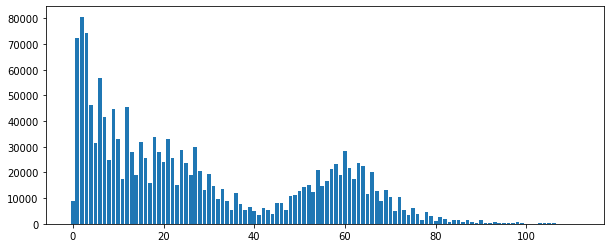

In [30]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,4))
depl_ori_weighted['timer_bin'] = depl_ori_weighted['autonomy_timer']//10
timer_repartition = (depl_ori_weighted[(depl_ori_weighted['autonomy_timer']>=0)]
                       .groupby('timer_bin')['scaling_factor_person'].sum()
                      .reset_index())
ax.bar(timer_repartition['timer_bin'], timer_repartition['scaling_factor_person'])
plt.show()

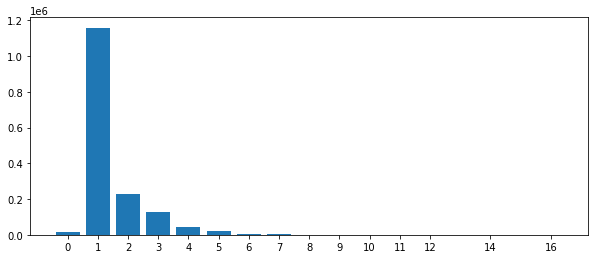

In [31]:
fig, ax = plt.subplots(figsize=(10,4))
counter_repartition = (depl_ori_weighted[(depl_ori_weighted['autonomy_counter']>=0)]
                       .groupby('autonomy_counter')['scaling_factor_person'].sum()
                      .reset_index())
ax.bar(counter_repartition['autonomy_counter'], counter_repartition['scaling_factor_person'])
ax.set_xticks(counter_repartition['autonomy_counter'])
plt.show()

In [32]:
timer_repartition['time'] = timer_repartition['timer_bin']

In [33]:
counter_repartition['frac_ori'] = counter_repartition['scaling_factor_person']/counter_repartition['scaling_factor_person'].sum()
counter_repartition.style.format(format_dict)

,autonomy_counter,scaling_factor_person,frac_ori
0,0.000000,17990.666780,1%
1,1.000000,1159069.192420,72%
2,2.000000,227365.974060,14%
3,3.000000,129509.527850,8%
4,4.000000,41225.339740,3%
5,5.000000,18681.702780,1%
6,6.000000,6934.574010,0%
7,7.000000,3843.720970,0%
8,8.000000,722.429120,0%
9,9.000000,770.295420,0%


### Activity purposes, before and after filtering
* [back to summary](#summary)

In [34]:

# counting purposes of each destinations
motive_hist = (depl_ori_weighted.groupby('destination_motive')['scaling_factor_person'].sum()
                                .rename('frac').reset_index())

# counting purposes of the first origin activity
origin_purpose_hist = (depl_ori_weighted[depl_ori_weighted['is_first_trip']]
                       .groupby('origin_motive')['scaling_factor_person'].sum())
motive_hist['frac'] = motive_hist['frac']+origin_purpose_hist

# counting all empty agenda as one home activity
nb_empty_agendas_ori = egt[egt['PENQ']==1]['scaling_factor_person'].sum() - depl_ori_weighted.groupby('id_per')['scaling_factor_person'].first().sum()
motive_hist.loc[motive_hist['destination_motive']==0, 'frac'] += nb_empty_agendas_ori

motive_hist['frac'] = motive_hist['frac']/motive_hist['frac'].sum()


# counting purposes of each destinations
motive_hist_filtered = (df_trips_weighted.groupby('following_purpose')['scaling_factor_person'].sum()
                                .rename('frac').reset_index())
motive_hist_filtered['following_purpose'] = motive_hist_filtered['following_purpose'].astype(int)

# counting purposes of the first origin activity
origin_purpose_hist = (df_trips_weighted[df_trips_weighted['is_first_trip']]
                       .groupby('preceding_purpose')['scaling_factor_person'].sum())
motive_hist_filtered['frac'] = motive_hist_filtered['frac']+origin_purpose_hist

# counting all empty agenda as one home activity
nb_empty_agendas_filtered = egt[egt['PENQ']==1]['scaling_factor_person'].sum() - df_trips_weighted.groupby('person_id')['scaling_factor_person'].first().sum()
motive_hist_filtered.loc[motive_hist_filtered['following_purpose']==0, 'frac'] += nb_empty_agendas_filtered

motive_hist_filtered['frac'] = motive_hist_filtered['frac']/motive_hist_filtered['frac'].sum()

motive_hist_merged = (motive_hist
 .merge(motive_hist_filtered, left_on='destination_motive', right_on='following_purpose', suffixes=('_ori', '_filtered'))
 .drop(columns=['destination_motive'])
 [['following_purpose', 'frac_ori', 'frac_filtered']]
)
motive_hist_merged.style.format(format_dict)


,following_purpose,frac_ori,frac_filtered
0,0,54%,60%
1,1,10%,11%
2,2,7%,9%
3,3,9%,6%
4,4,19%,13%


### Hour of trip, before and after filtering
* [back to summary](#summary)

In [35]:
df_trips_weighted['hour'] = df_trips_weighted['departure_time']//60

hour_hist = (depl_ori_weighted
               .groupby('hour')['scaling_factor_person'].sum()
                .rename('frac')
               .reset_index())
hour_hist['frac'] = hour_hist['frac']/hour_hist['frac'].sum()


hour_hist_filtered = (df_trips_weighted.groupby('hour')['scaling_factor_person'].sum()
                                .rename('frac').reset_index())
hour_hist_filtered['frac'] = hour_hist_filtered['frac']/hour_hist_filtered['frac'].sum()

hour_hist_merged = (hour_hist
 .merge(hour_hist_filtered, on='hour', suffixes=('_ori', '_filtered'), how="outer")
 .fillna(0)
)
hour_hist_merged['hour'] = hour_hist_merged['hour']%24
hour_hist_merged = hour_hist_merged.groupby('hour').sum().reset_index()
hour_hist_merged.style.format(format_dict)

,hour,frac_ori,frac_filtered
0,0,0%,0%
1,1,0%,0%
2,2,0%,0%
3,3,0%,0%
4,4,0%,0%
5,5,1%,1%
6,6,2%,2%
7,7,7%,9%
8,8,11%,10%
9,9,4%,4%


### Transport modes, before and after filtering
* [back to summary](#summary)

In [36]:

mode_hist = (depl_ori_weighted
               .groupby('MODP')['scaling_factor_person'].sum()
                .rename('frac')
               .reset_index())
mode_hist['frac'] = mode_hist['frac']/mode_hist['frac'].sum()

df_trips['MODP'] = df_trips['mode'].astype(int)
mode_hist_filtered = df_trips.groupby('MODP').size().reset_index().rename(columns={0:'frac'})
mode_hist_filtered['frac'] = mode_hist_filtered['frac']/mode_hist_filtered['frac'].sum()

mode_hist_merged = (mode_hist
 .merge(mode_hist_filtered, on='MODP', suffixes=('_ori', '_filtered'), how="outer")
 .fillna(0)
)
mode_hist_merged.style.format(format_dict)

,MODP,frac_ori,frac_filtered
0,0,36%,28%
1,1,2%,2%
2,2,43%,45%
3,3,19%,24%


### Plotting the distributions

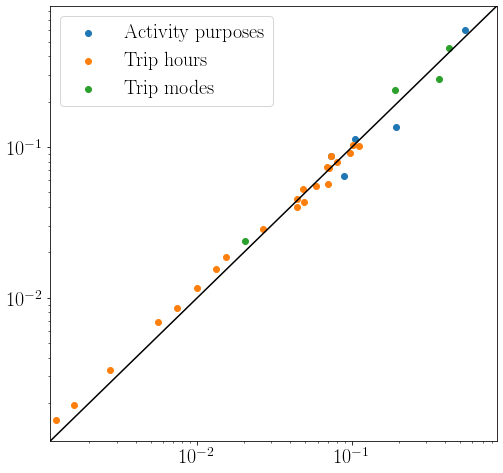

In [37]:
import matplotlib.pyplot as plt

fac_font = 2.5
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10*fac_font,
    "font.size": 10*fac_font,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8*fac_font,
    "xtick.labelsize": 8*fac_font,
    "ytick.labelsize": 8*fac_font
}
plt.rcParams.update(tex_fonts)


fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(motive_hist_merged['frac_ori'], motive_hist_merged['frac_filtered'], label='Activity purposes')
ax.scatter(hour_hist_merged['frac_ori'], hour_hist_merged['frac_filtered'], label='Trip hours')
ax.scatter(mode_hist_merged['frac_ori'], mode_hist_merged['frac_filtered'], label='Trip modes')
#ax.scatter(chain_len_distrib['frac_ori'], chain_len_distrib['frac_filtered'], label='nb of trips')
ax.set_xscale('log')
ax.set_yscale('log')
min_val = min(ax.get_xlim()[0], ax.get_ylim()[0])*4
max_val = max(ax.get_xlim()[1], ax.get_ylim()[1])
ax.plot([min_val, max_val], [min_val, max_val], color='k')
ax.set_xlim(min_val,max_val)
ax.set_ylim(min_val,max_val)
ax.legend()
plt.show()

<a id='primary'></a>
## Agendas featuring trips from primary activity to same primary activity
* There should be none of them.
* [back to summary](#summary)

In [38]:

anomalous_mask = np.zeros(len(activity_chains), dtype=bool)
for i in range(1, int(max_chain_len)):
    anomalous_mask = anomalous_mask | (activity_chains['dep_{}_motif'.format(i)].isin([0,1,2]) & 
                                       (activity_chains['dep_{}_motif'.format(i)]==activity_chains['dep_{}_motif'.format(i-1)]))


print('{} out of {} agendas ({:.2f}%) feature a bad transition primary -> primary'.format(sum(anomalous_mask),
                                                                   len(activity_chains),
                                                                   100*sum(anomalous_mask)/len(activity_chains)))

agenda_display(activity_chains[anomalous_mask].tail())

0 out of 17710 agendas (0.00%) feature a bad transition primary -> primary


,id_per,dep_0_motif,dep_0_zone,outsider,chain_len,zf_home,scaling_factor_person,dep_1_mode,dep_1_motif,dep_1_time,dep_1_l2,dep_1_zone,dep_1_arrival_time,dep_2_mode,dep_2_motif,dep_2_time,dep_2_l2,dep_2_zone,dep_2_arrival_time,dep_3_mode,dep_3_motif,dep_3_time,dep_3_l2,dep_3_zone,dep_3_arrival_time,dep_4_mode,dep_4_motif,dep_4_time,dep_4_l2,dep_4_zone,dep_4_arrival_time,dep_5_mode,dep_5_motif,dep_5_time,dep_5_l2,dep_5_zone,dep_5_arrival_time,dep_6_mode,dep_6_motif,dep_6_time,dep_6_l2,dep_6_zone,dep_6_arrival_time,dep_7_mode,dep_7_motif,dep_7_time,dep_7_l2,dep_7_zone,dep_7_arrival_time,dep_8_mode,dep_8_motif,dep_8_time,dep_8_l2,dep_8_zone,dep_8_arrival_time,dep_9_mode,dep_9_motif,dep_9_time,dep_9_l2,dep_9_zone,dep_9_arrival_time,dep_10_mode,dep_10_motif,dep_10_time,dep_10_l2,dep_10_zone,dep_10_arrival_time,dep_1_distbin,dep_2_distbin,dep_3_distbin,dep_4_distbin,dep_5_distbin,dep_6_distbin,dep_7_distbin,dep_8_distbin,dep_9_distbin,dep_10_distbin,autonomy,work_tm_in_agenda,work_in_agenda,study_in_agenda,need_commute


<a id='midnight'></a>
## Agendas go on after midnight
* [back to summary](#summary)

In [39]:
after_midnight_mask = np.zeros(len(activity_chains), dtype=bool)
for i in range(2, int(max_chain_len)):
    after_midnight_mask = after_midnight_mask | (activity_chains['dep_{}_time'.format(i)]<activity_chains['dep_{}_time'.format(i-1)])


print('{} out of {} agendas ({:.2f}%) go on after midnight'.format(sum(after_midnight_mask),
                                                                   len(activity_chains),
                                                                   100*sum(after_midnight_mask)/len(activity_chains)))

agenda_display(activity_chains[after_midnight_mask].tail())

237 out of 17710 agendas (1.34%) go on after midnight


,id_per,dep_0_motif,dep_0_zone,outsider,chain_len,zf_home,scaling_factor_person,dep_1_mode,dep_1_motif,dep_1_time,dep_1_l2,dep_1_zone,dep_1_arrival_time,dep_2_mode,dep_2_motif,dep_2_time,dep_2_l2,dep_2_zone,dep_2_arrival_time,dep_3_mode,dep_3_motif,dep_3_time,dep_3_l2,dep_3_zone,dep_3_arrival_time,dep_4_mode,dep_4_motif,dep_4_time,dep_4_l2,dep_4_zone,dep_4_arrival_time,dep_5_mode,dep_5_motif,dep_5_time,dep_5_l2,dep_5_zone,dep_5_arrival_time,dep_6_mode,dep_6_motif,dep_6_time,dep_6_l2,dep_6_zone,dep_6_arrival_time,dep_7_mode,dep_7_motif,dep_7_time,dep_7_l2,dep_7_zone,dep_7_arrival_time,dep_8_mode,dep_8_motif,dep_8_time,dep_8_l2,dep_8_zone,dep_8_arrival_time,dep_9_mode,dep_9_motif,dep_9_time,dep_9_l2,dep_9_zone,dep_9_arrival_time,dep_10_mode,dep_10_motif,dep_10_time,dep_10_l2,dep_10_zone,dep_10_arrival_time,dep_1_distbin,dep_2_distbin,dep_3_distbin,dep_4_distbin,dep_5_distbin,dep_6_distbin,dep_7_distbin,dep_8_distbin,dep_9_distbin,dep_10_distbin,autonomy,work_tm_in_agenda,work_in_agenda,study_in_agenda,need_commute
14159,520002911.000000,🏠,520002.000000,0.000000,2.000000,520002.000000,35.415920,🚗,🍻,20.0h,886.000000,520002.000000,2015.0h,🚗,🏠,2.0h,7110.000000,520002.000000,2730.0h,,,,nan,nan,,,,,nan,nan,,,,,nan,nan,,,,,nan,nan,,,,,nan,nan,,,,,nan,nan,,,,,nan,nan,,,,,nan,nan,,0.000000,0.000000,nan,nan,nan,nan,nan,nan,nan,nan,1.000000,None,False,False,False
14614,7050026463.000000,🏠,705002.000000,0.000000,2.000000,705002.000000,75.950130,🚗,🍻,20.0h,10430.000000,126008.000000,2200.0h,🚗,🏠,2.0h,10430.000000,705002.000000,2755.0h,,,,nan,nan,,,,,nan,nan,,,,,nan,nan,,,,,nan,nan,,,,,nan,nan,,,,,nan,nan,,,,,nan,nan,,,,,nan,nan,,7.000000,7.000000,nan,nan,nan,nan,nan,nan,nan,nan,1.000000,None,False,False,False
14642,7050033061.000000,🏠,705003.000000,0.000000,4.000000,705003.000000,42.264460,🚗,🛍️,9.0h,1230.000000,705003.000000,905.0h,🚗,🏭,16.0h,10520.000000,125001.000000,1715.0h,🚌,🍻,20.0h,127.000000,125001.000000,2010.0h,🚌,🏠,0.0h,11750.000000,705003.000000,2600.0h,,,,nan,nan,,,,,nan,nan,,,,,nan,nan,,,,,nan,nan,,,,,nan,nan,,,,,nan,nan,,0.000000,7.000000,0.000000,7.000000,nan,nan,nan,nan,nan,nan,3.000000,2.000000,True,False,True
14659,7050035641.000000,🏠,705003.000000,0.000000,6.000000,705003.000000,56.774330,🚌,🏭,8.0h,13470.000000,114005.000000,840.0h,🚌,🍻,12.0h,1060.000000,113006.000000,1240.0h,👣,🏭,12.0h,1739.000000,115004.000000,1345.0h,🚌,🏠,18.0h,19620.000000,705003.000000,1900.0h,🚗,🍻,20.0h,7810.000000,224005.000000,2115.0h,🚗,🏠,0.0h,7810.000000,705003.000000,2415.0h,,,,nan,nan,,,,,nan,nan,,,,,nan,nan,,,,,nan,nan,,7.000000,3.000000,3.000000,7.000000,5.000000,5.000000,nan,nan,nan,nan,3.000000,3.000000,True,False,True
14778,7060021033.000000,🏠,706002.000000,0.000000,4.000000,706002.000000,63.798310,🚗,🛍️,16.0h,13460.000000,128005.000000,1650.0h,🚗,🏠,18.0h,13460.000000,706002.000000,1840.0h,👣,🍻,20.0h,290.000000,706002.000000,2005.0h,👣,🏠,0.0h,290.000000,706002.000000,2505.0h,,,,nan,nan,,,,,nan,nan,,,,,nan,nan,,,,,nan,nan,,,,,nan,nan,,,,,nan,nan,,7.000000,7.000000,0.000000,0.000000,nan,nan,nan,nan,nan,nan,1.000000,None,False,False,False


<a id='homeend'></a>
## Somes agendas don't end at home
* [back to summary](#summary)

In [40]:

def get_last_motif(row):
    last_motif = 0
    motif = 0
    for i in range(1, int(max_chain_len)+1):
        motif = row['dep_{}_motif'.format(i)]
        if np.isnan(motif):
            return last_motif
        else:
            last_motif=motif
    return last_motif

activity_chains['last_motif'] = activity_chains.apply(get_last_motif, axis=1)
print('{} out of {} agendas ({:.2g}%) don\'t end at home after filtering'.format(sum(activity_chains['last_motif']!=0),
                                                                              len(activity_chains),
                                                                              100*(activity_chains['last_motif']!=0).mean()))
agenda_display(activity_chains[activity_chains['last_motif']!=0].head())

932 out of 17710 agendas (5.3%) don't end at home after filtering


,id_per,dep_0_motif,dep_0_zone,outsider,chain_len,zf_home,scaling_factor_person,dep_1_mode,dep_1_motif,dep_1_time,dep_1_l2,dep_1_zone,dep_1_arrival_time,dep_2_mode,dep_2_motif,dep_2_time,dep_2_l2,dep_2_zone,dep_2_arrival_time,dep_3_mode,dep_3_motif,dep_3_time,dep_3_l2,dep_3_zone,dep_3_arrival_time,dep_4_mode,dep_4_motif,dep_4_time,dep_4_l2,dep_4_zone,dep_4_arrival_time,dep_5_mode,dep_5_motif,dep_5_time,dep_5_l2,dep_5_zone,dep_5_arrival_time,dep_6_mode,dep_6_motif,dep_6_time,dep_6_l2,dep_6_zone,dep_6_arrival_time,dep_7_mode,dep_7_motif,dep_7_time,dep_7_l2,dep_7_zone,dep_7_arrival_time,dep_8_mode,dep_8_motif,dep_8_time,dep_8_l2,dep_8_zone,dep_8_arrival_time,dep_9_mode,dep_9_motif,dep_9_time,dep_9_l2,dep_9_zone,dep_9_arrival_time,dep_10_mode,dep_10_motif,dep_10_time,dep_10_l2,dep_10_zone,dep_10_arrival_time,dep_1_distbin,dep_2_distbin,dep_3_distbin,dep_4_distbin,dep_5_distbin,dep_6_distbin,dep_7_distbin,dep_8_distbin,dep_9_distbin,dep_10_distbin,autonomy,work_tm_in_agenda,work_in_agenda,study_in_agenda,need_commute,last_motif
7,1010021171.000000,🏭,101002.000000,0.000000,2.000000,101002.000000,51.747090,🚗,🍻,10.0h,1430.000000,103006.000000,1015.0h,🚗,🏭,10.0h,1430.000000,101002.000000,1130.0h,,,,nan,nan,,,,,nan,nan,,,,,nan,nan,,,,,nan,nan,,,,,nan,nan,,,,,nan,nan,,,,,nan,nan,,,,,nan,nan,,3.000000,3.000000,nan,nan,nan,nan,nan,nan,nan,nan,3.000000,2.000000,True,False,True,🏭
213,10200281.000000,🏠,102002.000000,0.000000,2.000000,102002.000000,45.940260,👣,🍻,14.0h,1739.000000,103005.000000,1530.0h,👣,🍻,17.0h,1739.000000,102002.000000,1800.0h,,,,nan,nan,,,,,nan,nan,,,,,nan,nan,,,,,nan,nan,,,,,nan,nan,,,,,nan,nan,,,,,nan,nan,,,,,nan,nan,,2.000000,2.000000,nan,nan,nan,nan,nan,nan,nan,nan,2.000000,None,False,False,False,🍻
263,1020041192.000000,🏠,102004.000000,0.000000,3.000000,102004.000000,64.389620,🚌,📚,8.0h,8470.000000,201651.000000,835.0h,🚌,🏠,12.0h,8470.000000,102004.000000,1245.0h,🚌,🏭,16.0h,2640.000000,126004.000000,1700.0h,,,,nan,nan,,,,,nan,nan,,,,,nan,nan,,,,,nan,nan,,,,,nan,nan,,,,,nan,nan,,,,,nan,nan,,6.000000,6.000000,3.000000,nan,nan,nan,nan,nan,nan,nan,1.000000,3.000000,True,True,True,🏭
265,1020041301.000000,🏠,102004.000000,0.000000,5.000000,102004.000000,54.067310,🚌,📚,8.0h,2660.000000,116001.000000,855.0h,👣,🍻,12.0h,290.000000,116001.000000,1205.0h,👣,📚,12.0h,290.000000,116001.000000,1300.0h,🚌,🏠,18.0h,1270.000000,102004.000000,1820.0h,🚌,🍻,19.0h,1680.000000,129003.000000,1925.0h,,,,nan,nan,,,,,nan,nan,,,,,nan,nan,,,,,nan,nan,,,,,nan,nan,,3.000000,0.000000,0.000000,3.000000,2.000000,nan,nan,nan,nan,nan,3.000000,None,False,True,True,🍻
303,1030011603.000000,🏠,103001.000000,0.000000,1.000000,103001.000000,34.759000,🚌,🏭,20.0h,11480.000000,208751.000000,2230.0h,,,,nan,nan,,,,,nan,nan,,,,,nan,nan,,,,,nan,nan,,,,,nan,nan,,,,,nan,nan,,,,,nan,nan,,,,,nan,nan,,,,,nan,nan,,6.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.000000,3.000000,True,False,True,🏭


In [41]:
activity_chains.groupby('dep_0_motif')['id_per'].size()

dep_0_motif
0.0    16682
1.0      529
2.0       63
3.0      130
4.0      306
Name: id_per, dtype: int64

<a id='static'></a>
## Static persons in EGT
* Taking EGT as we have filtered it and activity chains that we have filtered.
* [back to summary](#summary)

In [42]:
activity_chains = activity_chains.fillna(0)
max_chain_len = int(activity_chains['chain_len'].max())

locations = activity_chains[['dep_{}_zone'.format(i) for i in range(max_chain_len+1)]].values
moved = (locations[:,1:] != locations[:,:-1])
padding = locations[:,1:]==0
activity_chains['static'] = (~(moved & ~padding)).all(axis=1)
activity_chains['empty'] = activity_chains['chain_len']==0

egt_path = os.path.join(config['outdata_dir']['path'], config['outdata_dir']['HTS_filtered_filename'])
egt = pd.read_csv(egt_path, dtype={'zf_home':str})
egt = egt.merge(activity_chains, on='id_per', suffixes=('', '_drop'))
egt = egt.drop(columns=[col for col in egt.columns if col.endswith('_drop')])

nb_people = egt['scaling_factor_person'].sum()
nb_empty = (egt['empty'] * egt['scaling_factor_person']).sum()
nb_non_empty_static = ((egt['static'] & ~egt['empty']) * egt['scaling_factor_person']).sum()
print('{:.2f}% of people in EGT have an empty agenda'.format(100*nb_empty/nb_people))
print('{:.2f}% of people in EGT have a non-empty, static agenda'.format(100*nb_non_empty_static/nb_people))

21.19% of people in EGT have an empty agenda
7.21% of people in EGT have a non-empty, static agenda


* counting only EGT respondant inside our study zone: 

In [43]:
zf_path = os.path.join(config['outdata_dir']['path'], config['outdata_dir']['HTS_gis_filtered_filename'])
zf = gpd.read_file(zf_path)
zf['commune'] = zf['DComIris'].str[:5]
zf['commune'] = zf['commune'].replace({'A':'69290'})  # cleaning one zf

egt['zf_home'] = egt['zf_home'].str[2:]  # removing '00'
egt = egt.drop(columns=['commune'])
egt = egt.merge(zf[['ZF2015_Nouveau_codage', 'commune']], left_on='zf_home', right_on='ZF2015_Nouveau_codage', how='left')

print('{} out of {} ({:.0f}%) of egt respondant are outside of study area'.format(
    egt['commune'].isna().sum(), len(egt), 100*egt['commune'].isna().sum()/len(egt)))
egt = egt[~egt['commune'].isna()]

print('counting only EGT respondant inside our study zone:')
(egt['static'] * egt['scaling_factor_person']).sum() / egt['scaling_factor_person'].sum()

16941 out of 16941 (100%) of egt respondant are outside of study area
counting only EGT respondant inside our study zone:


/var/folders/4m/96kct6fd1vl7ty8sc_mpj7kw0000gp/T/ipykernel_15344/4216809702.py:15: RuntimeWarning: invalid value encountered in double_scalars
  (egt['static'] * egt['scaling_factor_person']).sum() / egt['scaling_factor_person'].sum()


nan

<a id='static_egtraw'></a>
## Counting empty and static agendas in EGT without our preprocessing
* Taking strictly raw EGT and activity chains, see how many empty and static agendas we got.
* For better fairness, we take only EGT respondant resident of the study area.
* [back to summary](#summary)

In [44]:
c=Chrono('Reading zf...')
zf = gpd.read_file('/Users/benoit/Desktop/Pro/210526-fusion/outdata/egt_lyon_pop_sample/zf_map.csv')
zf['commune'] = zf['DComIris'].str[:5]
zf['commune'] = zf['commune'].replace({'A':'69290'})  # cleaning one zf
zf['ZF2015_Nouveau_codage'] = zf['ZF2015_Nouveau_codage'].astype(float)

c.write('Reading per...')

per_faf = pd.read_csv('../../data/EGT_lyon/csv/Fichiers_Standard_Face_a_face/lyon_2015_std_faf_pers.csv', 
                      sep=';', dtype={'ZFP':str, 'ECH':str,'PER':str})
per_tel = pd.read_csv('../../data/EGT_lyon/csv/Fichiers_Standard_Telephone/lyon_2015_std_tel_pers.csv', 
                      sep=';', dtype={'ZFP':str, 'ECH':str,'PER':str})
per = pd.concat([per_faf, per_tel])
per['id_men'] = per['ZFP'] + per['ECH']
per['id_per'] = per['id_men'] + per['PER']
per = per.drop(['ECH'], axis=1)
c.write('{} rows ({} in faf - {} in tel)'.format(len(per), len(per_faf), len(per_tel)))

c.write('Keeping only the ones living in the study zone...')
per['ZFP'] = per['ZFP'].astype(float)
per = per.merge(zf[['ZF2015_Nouveau_codage', 'commune']], 
                left_on='ZFP', right_on='ZF2015_Nouveau_codage', how='left')
per = per[~per['ZF2015_Nouveau_codage'].isna()]
c.write('{} rows'.format(len(per)))


per_answered_agendas = per[per['PENQ']==True][['id_per', 'ZFP', 'COE1']]
per_answered_agendas['id_per'] = per_answered_agendas['id_per'].astype(float)
c.write('Keeping only the {} who have declared a (potentially empty) agenda'.format(len(per_answered_agendas)))


#depl_ori = pd.read_csv('/Users/benoit/Desktop/Pro/210526-fusion/outdata/egt_lyon_pop_sample/depl.csv', sep=';',
#                  dtype={'D4':str, 'D8':str, 'id_per':str})
#
c.write('Reading depl...')
depl_faf = pd.read_csv('../../data/EGT_lyon/csv/Fichiers_Standard_Face_a_face/lyon_2015_std_faf_depl.csv', sep=';', dtype={'D4':str, 'D8':str, 'ZFD':str, 'ECH':str,'PER':str, 'NDEP':str})
depl_tel = pd.read_csv('../../data/EGT_lyon/csv/Fichiers_Standard_Telephone/lyon_2015_std_tel_depl.csv', sep=';', dtype={'D4':str, 'D8':str, 'ZFD':str, 'ECH':str,'PER':str, 'NDEP':str})
depl = pd.concat([depl_faf,depl_tel])
depl['id_per'] = depl['ZFD'] + depl['ECH'] + depl['PER']
depl['id_dep'] = depl['id_per'] + depl['NDEP']
depl = depl.drop(['ECH', 'PER'], axis=1)
c.write('{} rows ({} in faf - {} in tel)'.format(len(depl), len(depl_faf), len(depl_tel)))

c.write('Detecting static and empty...')
def is_static_agg(rows):
    return (rows['D3'].values[0] == rows['D7'].values).all()
static_trajs = depl.groupby('id_per').apply(is_static_agg).rename('is_static').reset_index()
static_trajs['id_per'] = static_trajs['id_per'].astype(int)

static_trajs = static_trajs.merge(per_answered_agendas, how='outer', on='id_per')
static_trajs['is_empty'] = static_trajs['is_static'].isna()

nb_people = static_trajs['COE1'].sum()
nb_empty = (static_trajs['is_empty'] * static_trajs['COE1']).sum()
nb_non_empty_static = ((static_trajs['is_static'] & ~static_trajs['is_empty']) * static_trajs['COE1']).sum()
c.write('{:.2f}% of people in EGT have an empty agenda'.format(100*nb_empty/nb_people))
c.write('{:.2f}% of people in EGT have a non-empty, static agenda'.format(100*nb_non_empty_static/nb_people))


14:48:34	Reading zf...
00:00:00	Reading per...
00:00:00	36564 rows (21061 in faf - 15503 in tel)
00:00:00	Keeping only the ones living in the study zone...
00:00:00	18572 rows
00:00:00	Keeping only the 16941 who have declared a (potentially empty) agenda
00:00:00	Reading depl...
00:00:01	99585 rows (68153 in faf - 31432 in tel)
00:00:01	Detecting static and empty...
00:00:04	10.97% of people in EGT have an empty agenda
00:00:04	7.83% of people in EGT have a non-empty, static agenda


<a id='code_viz'></a>
# Code visualisation
* [back to summary](#summary)

## `create_chain`

In [45]:
target_per = '00101004681'  # home->home suppression
# target_per = '00101003641'  # big trips on foot that has been suppressed
#target_per = '0010300722'  # complicated example
target_per = '00101002371' # after midnight

depl_ori['D4_minutes'] = depl_ori['D4'].str[:2].astype(int)*60 + depl_ori['D4'].str[2:].astype(int)
depl_ori['D8_minutes'] = depl_ori['D8'].str[:2].astype(int)*60 + depl_ori['D8'].str[2:].astype(int)
depl_ori['chain'] = depl_ori[['MODP', 'destination_motive', 'D4']].apply(tuple, axis=1)

testgroup = depl_ori[depl_ori['id_per']==target_per]
print('id_per:', target_per)
agenda_display(testgroup
 [['D4', 'D8', 'origin_motive', 'MODP', 'destination_motive', 'D11']]
              .rename(columns={'origin_motive':'motif_o', 
                               'destination_motive':'motif_d',
                              'MODP':'mode',
                              'D11':'distance (m)'}))

#print('starting time of activities : \t{}'.format(testgroup['D8_minutes'].values))
#print('ending time of activities : \t{}'.format(np.concatenate([testgroup['D4_minutes'].values[1:], [np.inf]])))
print('chain: \t{}'.format(create_chain(testgroup, min_activity_duration=20)))


id_per: 00101002371


,D4,D8,motif_o,mode,motif_d,distance (m)


IndexError: index 0 is out of bounds for axis 0 with size 0